# <b>Fake & Real News Dataset</b>

#### <strong>Purpose</strong>

<strong>Fake News Detection</strong>
<br>
![Fake News GIF](gifs/Cnn%20News%20GIF.gif)

    The dataset is meant to support fake news detection.

#### <strong>Objectives</strong>

##### Build and Evaluate a Classifier

![Predict GIF](gifs/Season%202%20Rolls%20Eyes%20GIF%20by%20BBC%20Three.gif)

<ul>
    <li>Use the title and/or text fields to train a supervised learning model that predicts the label (fake vs. real).</li>
    <li>Benchmark different models (e.g., logistic regression, random forest, transformers) to see which performs best.</li>
</ul>

##### Analyze Patterns of Fake vs. Real News

![Analyze](gifs/Serious%20Episode%205%20GIF%20by%20One%20Chicago.gif)

<ul>
<li>Explore linguistic and metadata differences (e.g., vocabulary, sentiment, writing style, publishing source, frequency of certain words).</li>
<li>Identify features that strongly correlate with fake news, which could also help in understanding misinformation strategies.</li>
</ul>

### <strong>Setup & Data Loading</strong>

#### Import Libraries

In [58]:
import pandas as pd
import numpy as np

# Preprocessing
import re
import string
import nltk

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("punkt_tab")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Graphs/EDA
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /home/kimo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kimo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/kimo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/kimo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Reading the File & Exploring the Data

In [59]:
data = pd.read_csv('fake_news_dataset.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  200 non-null    object
 1   title       20000 non-null  object
 2   text        20000 non-null  object
 3   date        20000 non-null  object
 4   url         200 non-null    object
 5   source      19000 non-null  object
 6   author      19000 non-null  object
 7   thumbnail   200 non-null    object
 8   category    20000 non-null  object
 9   label       20000 non-null  object
dtypes: object(10)
memory usage: 1.5+ MB


,article_id,title,text,date,url,source,author,thumbnail,category,label
0,ART00001,Foreign Democrat final.,more tax development both store agreement lawy...,10/03/2023,https://newswebsite.com/article/1,NY Times,Paula George,https://images.newswebsite.com/thumb1.jpg,Politics,real
1,ART00002,To offer down resource great point.,probably guess western behind likely next inve...,25/05/2022,https://newswebsite.com/article/2,Fox News,Joseph Hill,https://images.newswebsite.com/thumb2.jpg,Politics,fake
2,ART00003,Himself church myself carry.,them identify forward present success risk sev...,01/09/2022,https://newswebsite.com/article/3,CNN,Julia Robinson,https://images.newswebsite.com/thumb3.jpg,Business,fake
3,ART00004,You unit its should.,phone which item yard Republican safe where po...,07/02/2023,https://newswebsite.com/article/4,Reuters,Mr. David Foster DDS,https://images.newswebsite.com/thumb4.jpg,Science,fake
4,ART00005,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,03/04/2023,https://newswebsite.com/article/5,CNN,Austin Walker,https://images.newswebsite.com/thumb5.jpg,Technology,fake


### <strong>Initial Cleaning<strong>

#### Dropping IrrelevantColumns

In [60]:
data = data.drop(columns=["article_id", "url", "thumbnail"], errors="ignore")

data.head()

,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,10/03/2023,NY Times,Paula George,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,25/05/2022,Fox News,Joseph Hill,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,01/09/2022,CNN,Julia Robinson,Business,fake
3,You unit its should.,phone which item yard Republican safe where po...,07/02/2023,Reuters,Mr. David Foster DDS,Science,fake
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,03/04/2023,CNN,Austin Walker,Technology,fake


#### Remove Duplicates

In [61]:
data = data.drop_duplicates(subset=["title", "text"])

#### Handle Missing Values

In [62]:
# Replace blank/whitespace-only cells with NaN
data = data.replace(r'^\s*$', np.nan, regex=True)

# Drop rows where 'text' or 'title' are missing
data = data.dropna(subset=["text", "title"])

# Fill missing metadata
data["author"] = data["author"].fillna("Unknown")
data["source"] = data["source"].fillna("Unknown")

#### Convert Date Column to Datetime

In [63]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

data['date'] = data['date'].fillna(pd.NaT)

In [64]:

# Drop rows where date is completely invalid
data = data.dropna(subset=["date"])

### <strong>Text & Metadata Normalization</strong>

#### Clean Source Column

In [65]:
# Lowercase everything first
data["source"] = data["source"].str.lower().str.strip()

# Remove common URL parts like '.com', '.org', '.net'
data["source"] = data["source"].str.replace(r"\.com|\.org|\.net|\.news", "", regex=True)

# Remove 'www.' and ending slashes
data["source"] = data["source"].str.replace(r"^www\.", "", regex=True)
data["source"] = data["source"].str.replace(r"/$", "", regex=True)

In [66]:
print(data["source"].value_counts().head(20))

source
ny times        954
reuters         946
daily news      934
cnn             928
bbc             921
fox news        916
global times    880
the guardian    878
unknown         405
Name: count, dtype: int64


#### Clean Title & Text Columns

In [67]:
def clean_text(text):
    text = str(text).lower()
    text = text.strip()
    text = " ".join(text.split())
    return text

data["title"] = data["title"].apply(clean_text)
data["text"] = data["text"].apply(clean_text)

### <strong>Quality Control & Filtering</strong>

#### Add Text Length Column & Filter by Length

In [68]:
# Add text length column
data["text_length"] = data["text"].apply(len)

# Keep only rows with reasonable text length
data = data[(data["text_length"] > 30) & (data["text_length"] < 10000)]

#### Convert Label to Numeric

In [69]:
# If label is text ("fake"/"real") → convert to numeric
data["label"] = data["label"].str.lower().map({"fake": 0, "real": 1})

# Handle missing or invalid labels
data = data.dropna(subset=["label"])

#### Preprocess Text (Remove URLs, Numbers, Punctuation, Stopwords, Lemmatize)

In [70]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords + lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Rejoin tokens
    return " ".join(tokens)

# Apply preprocessing
data["clean_text"] = data["text"].apply(preprocess_text)
data["clean_title"] = data["title"].apply(preprocess_text)

### <strong>Feature Engineering</strong>

#### Add Word Count and Ratio Features

In [71]:
# Word count features
data["word_count"] = data["clean_text"].apply(lambda x: len(x.split()))
data["title_word_count"] = data["clean_title"].apply(lambda x: len(x.split()))

# Ratio feature (title length vs body length)
data["title_to_text_ratio"] = data["title_word_count"] / (data["word_count"] + 1)

#### Date / Time Features

In [72]:
# --- Date/time features ---
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["dayofweek"] = data["date"].dt.dayofweek  # Mon=0


#### Source/Author productivity & frequency

In [73]:
# --- Source/Author productivity & frequency ---
src_counts = data["source"].value_counts()
data["source_freq"] = data["source"].map(src_counts)

#### Frequency of Author in Corpus

In [74]:
auth_counts = data["author"].value_counts()
data["author_freq"] = data["author"].map(auth_counts)

#### Author/Article Recency Feature (how many days since article)

In [75]:
max_date = data["date"].max()
data["days_since_pub"] = (max_date - data["date"]).dt.days

### <strong>Exploratory Data Analysis (EDA)</strong>

#### Visualize Label Distribution

/tmp/ipykernel_7831/2260486128.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=data, palette="Set2")


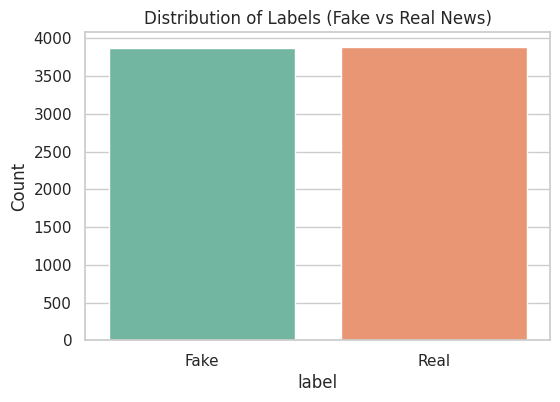

In [76]:
sns.set(style="whitegrid")

# --- Label Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=data, palette="Set2")
plt.title("Distribution of Labels (Fake vs Real News)")
plt.xticks([0,1], ["Fake", "Real"])
plt.ylabel("Count")
plt.show()

#### Visualize Text Length Distribution

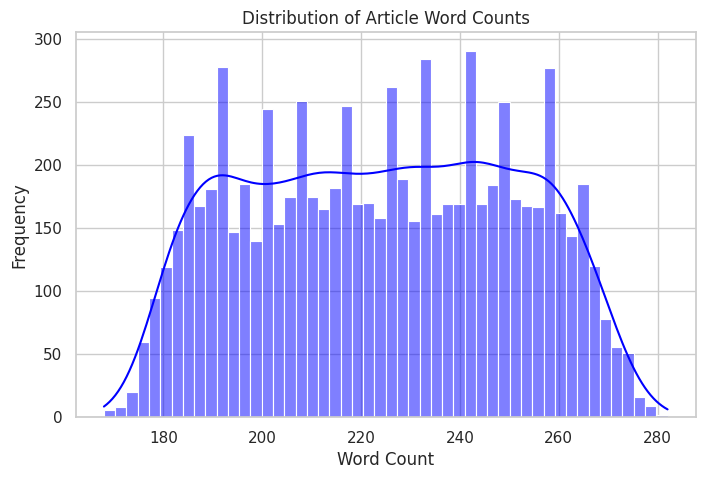

In [77]:
# --- Text Length Distribution ---
plt.figure(figsize=(8,5))
sns.histplot(data["word_count"], bins=50, kde=True, color="blue")
plt.title("Distribution of Article Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

#### Visualize Title vs Text Ratio Distribution

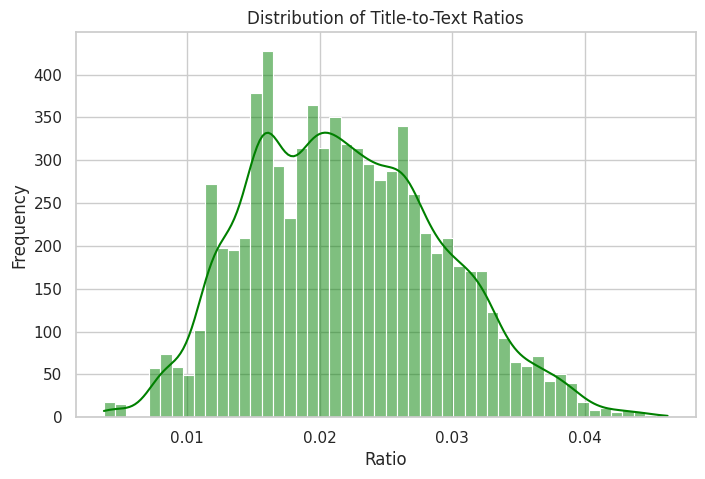

In [78]:
# --- Title vs Text Ratio ---
plt.figure(figsize=(8,5))
sns.histplot(data["title_to_text_ratio"], bins=50, kde=True, color="green")
plt.title("Distribution of Title-to-Text Ratios")
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.show()

#### Visualize Top Sources

/tmp/ipykernel_7831/1853544501.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sources.values, y=top_sources.index, palette="muted")


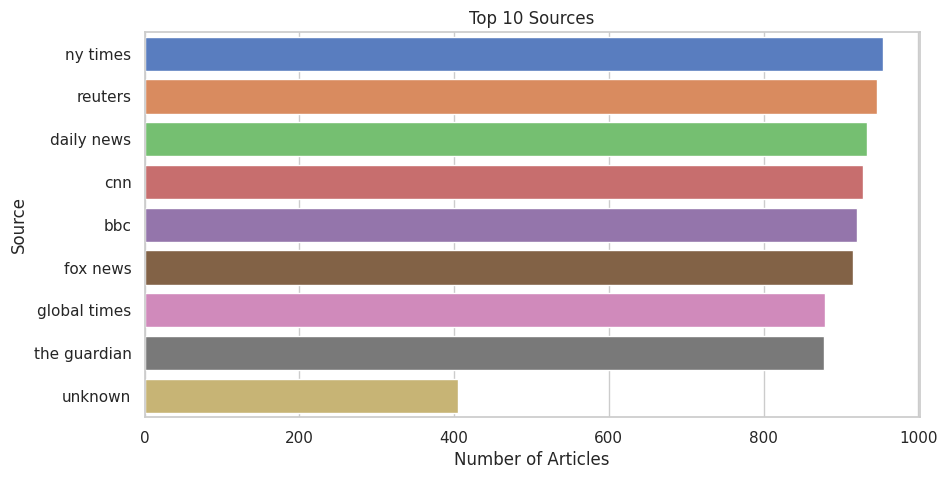

In [79]:
# --- Top Sources ---
plt.figure(figsize=(10,5))
top_sources = data["source"].value_counts().head(10)
sns.barplot(x=top_sources.values, y=top_sources.index, palette="muted")
plt.title("Top 10 Sources")
plt.xlabel("Number of Articles")
plt.ylabel("Source")
plt.show()

### <strong>Save Processed Dataset</strong>

#### Save and Download Cleaned Data

In [81]:
data.to_csv('cleaned_fake_news.csv', index=False)